In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'pix2pix' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
BUFFER_SIZE = 400
IMG_SIZE = 256 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 3

In [3]:
# Funkcije za ucitavanje podataka
dataset_dictionary = {
    'facades': (r'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz', True)
}

def download_dataset(dataset_name: str) -> None:
    assert dataset_name in dataset_dictionary, 'Izabran skup podataka ne postoji'
    dataset_url, zipped = dataset_dictionary[dataset_name]
    keras.utils.get_file(origin=dataset_url, extract=zipped, cache_dir=MASTER_FOLDER, cache_subdir='datasets')
    return f'{MASTER_FOLDER}/datasets/{dataset_name}'

def load_image(image_file: str) -> tf.Tensor:
    # Ucitavanje slike
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Svaka slika u podacima predstavlja spojenu sliku skice i prave slike koje su spojene vertikalno
    n = tf.shape(image)[1] // 2
    input_image = image[:, n:, :]
    real_image = image[:, :n, :]

    # Slike se konvertuju u tensor i skaliraju se na internal [0, 1]
    input_image = tf.cast(input_image, tf.float32) / 255.0
    real_image = tf.cast(real_image, tf.float32) / 255.0

    return input_image, real_image

def load_data(path: str) -> np.ndarray:
    dataset = tf.data.Dataset.list_files(f'{path}/*.jpg')
    dataset = dataset.map(load_image)
    dataset = dataset.shuffle(BUFFER_SIZE)
    return dataset.batch(BATCH_SIZE)

def load_dataset(dataset_name: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dataset_path = download_dataset(dataset_name)
    train_data = load_data(f'{dataset_path}/train')
    val_data = load_data(f'{dataset_path}/val')
    test_data = load_data(f'{dataset_path}/test')
    return train_data, val_data, test_data

tf_train, tf_val, tf_test = load_dataset('facades')

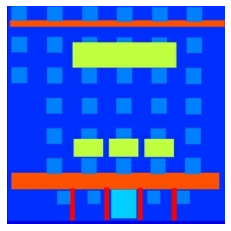

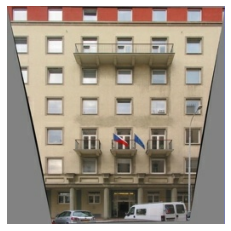

In [4]:
from library.visualization import show_image

for x, y in tf_train.take(1):
    assert x.shape == y.shape and x.shape == (40, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
    show_image(x[10])
    show_image(y[10])

In [5]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    
    generator_builder.add_downsample_layer(64, 4, apply_batchnorm=False)
    generator_builder.add_downsample_layer(128, 4)
    generator_builder.add_downsample_layer(256, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4)
    generator_builder.add_upsample_layer(256, 4)
    generator_builder.add_upsample_layer(128, 4)
    generator_builder.add_upsample_layer(64, 4)
    
    return generator_builder.build()

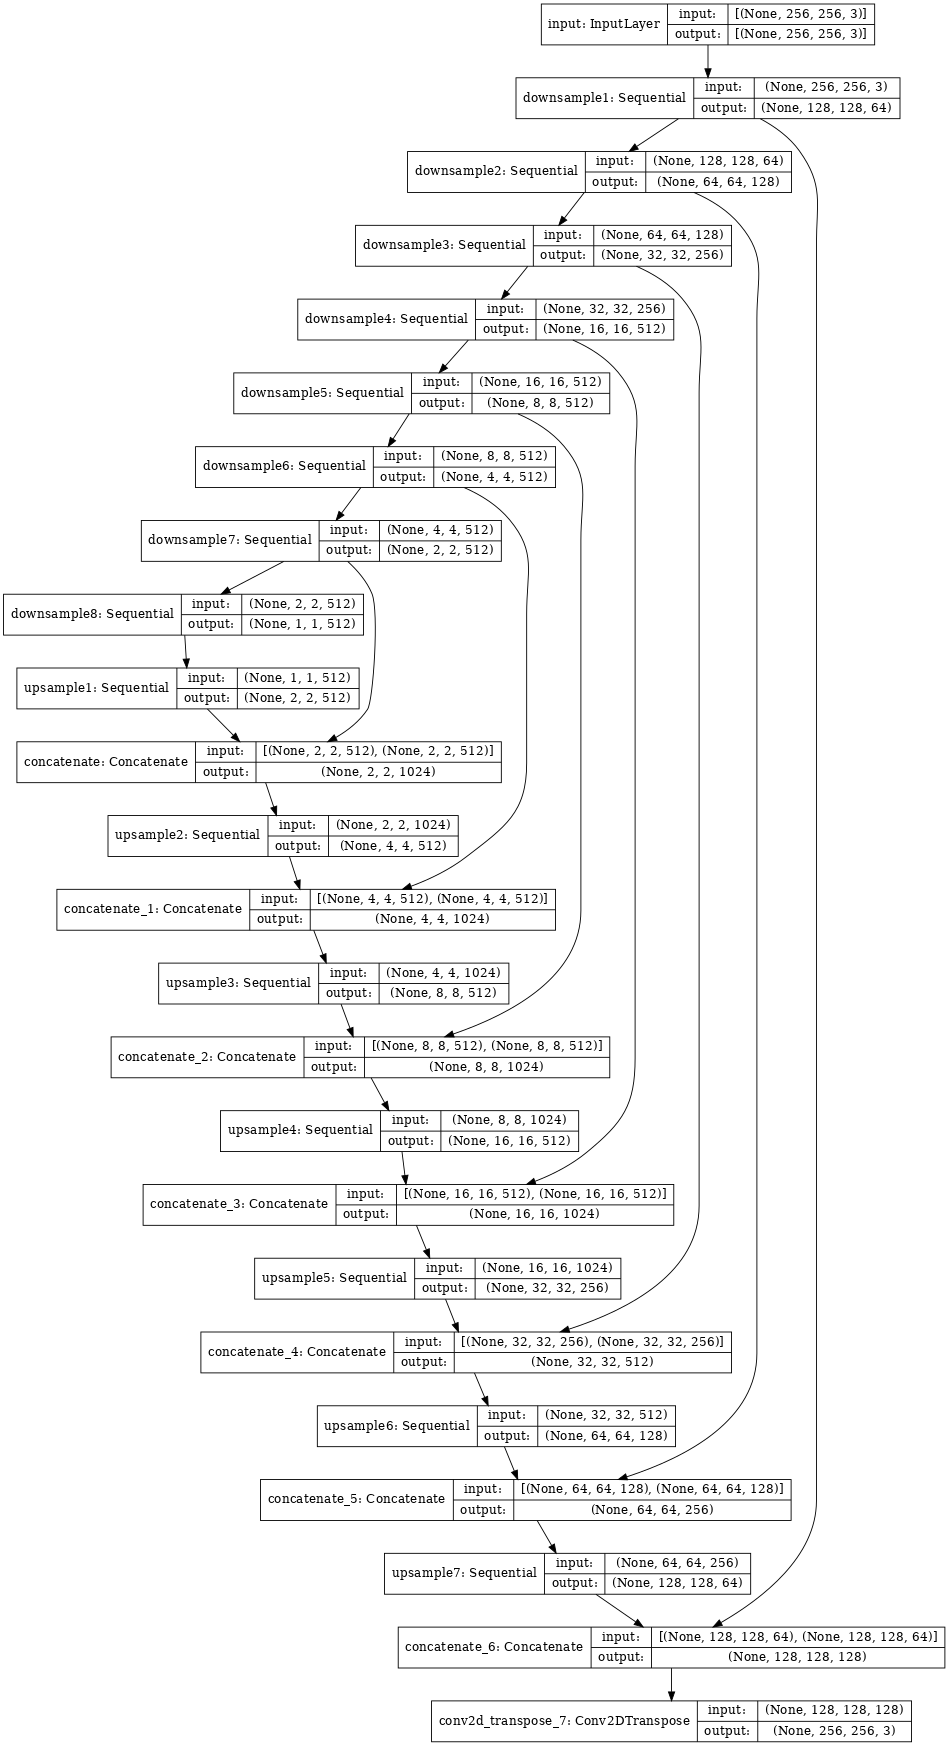

In [6]:
generator = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator, show_shapes=True, dpi=64)

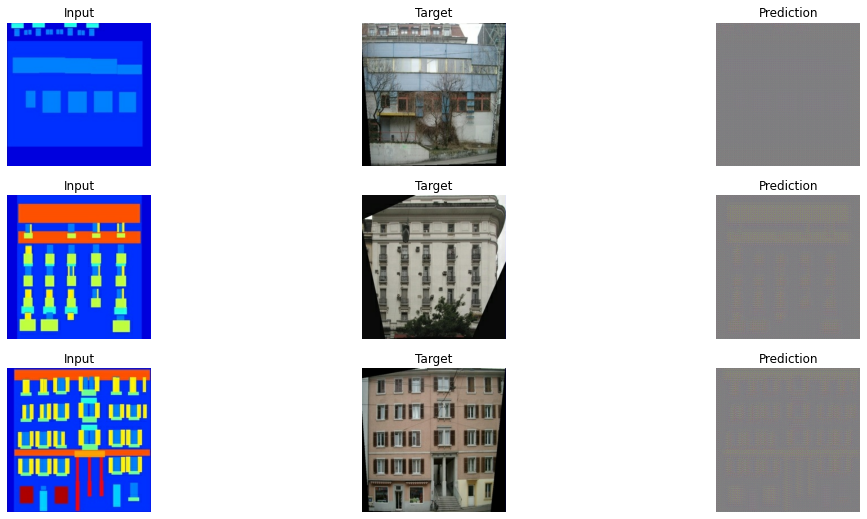

In [7]:
from library.visualization import test_image_generation

for input_batch, target_batch in tf_train.take(1):
    test_image_generation(generator, input_batch, target_batch, img_size=IMG_SIZE)

In [8]:
from library.unet_generator import downsample

def create_discriminator():
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = create_discriminator()

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

In [11]:
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

Time taken for 20 steps: 586.76 sec



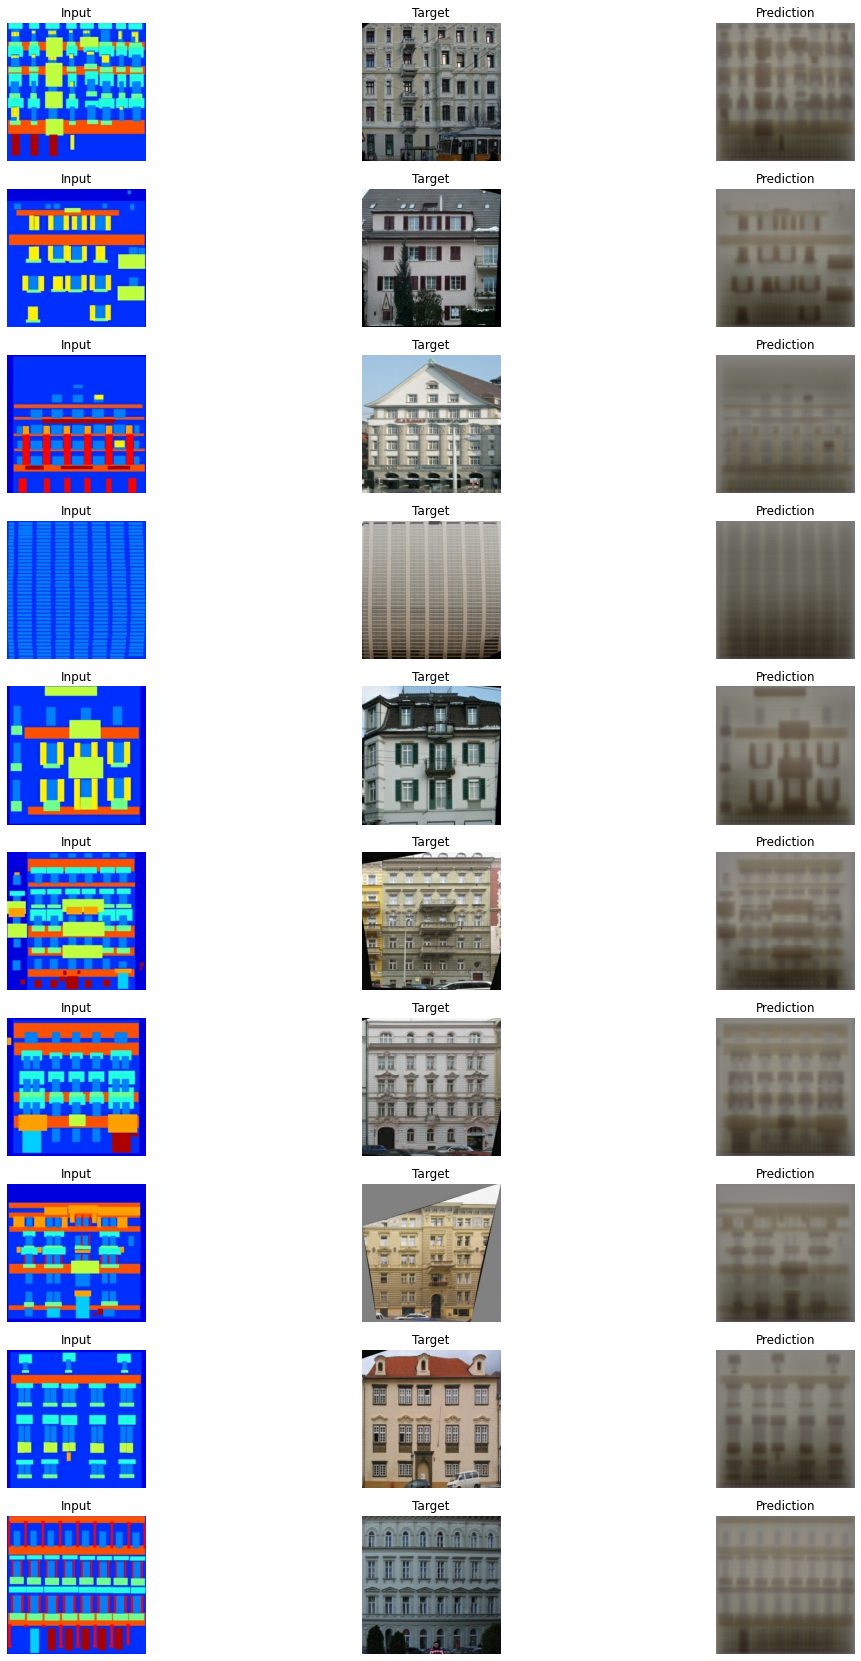

Step: 20
.........

In [ ]:
from library.cgan import CGAN

cgan = CGAN(
  generator=generator,
  discriminator=discriminator,
  alpha=100,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  img_size=IMG_SIZE,
  summary_writer=summary_writer,
  checkpoint=checkpoint,
  checkpoint_prefix=checkpoint_prefix
)
train_history, val_history = cgan.fit(tf_train, tf_val, steps=50, test_generation_period=10, n_test_examples=10)

In [ ]:
from library.visualization import plot_training_results

plot_training_results(train_history, val_history)
plt.show()